# Testing the tools to analyse lines in XP spectra developed in [Weiler+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A..52W/abstract)


In [1]:
import weiler2023_tools
import numpy as np
import scipy
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.special import hermite, factorial

## 1. Hermite functions

In [2]:
import importlib
importlib.reload(weiler2023_tools)

<module 'weiler2023_tools' from '/home/friedel/Desktop/xp_spectral_lines/weiler2023_tools.py'>

Text(0.5, 1.0, 'Hermite functions')

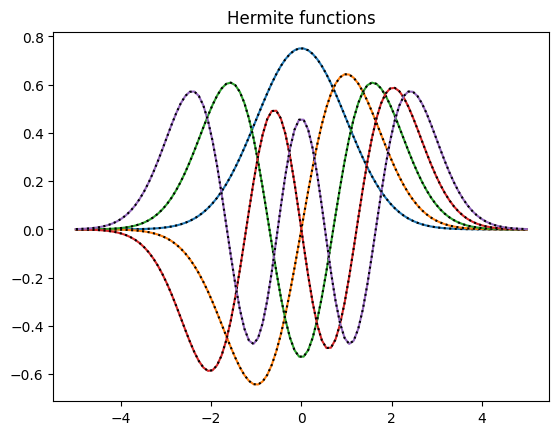

In [3]:
x    = np.linspace(-5,5,100)
test = weiler2023_tools.HermiteFunction(x, 55, scipy=False)
# Test if our implementation is correct using the scipy Hermite polynomials
test2= weiler2023_tools.HermiteFunction(x, 55, scipy=True)

for ii in np.arange(0,5):
    plt.plot(x, test[:,ii])
    plt.plot(x, test2[:,ii], c="k", ls="dotted")

plt.title("Hermite functions")

## 2. Read the configuration data files

The data are stored in ./ConfigurationData and can be read as follows:

In [4]:
XPConstants = weiler2023_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")

## 3. Visualise some of the involved matrices

The transformation matrices for BP and RP:

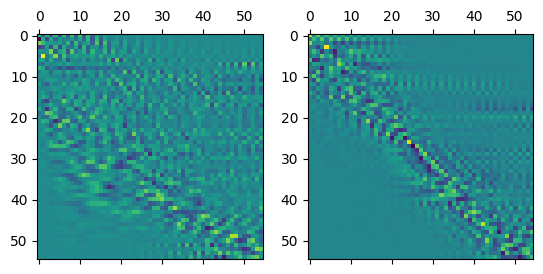

In [5]:
ax0 = plt.subplot(121)
ax0.matshow(XPConstants.TrafoBP)
ax1 = plt.subplot(122)
ax1.matshow(XPConstants.TrafoRP)

The derivative matrices (shown only for the first 10 Hermite functions):

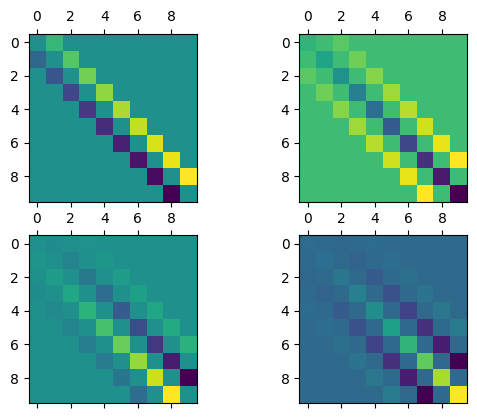

In [6]:
ax0 = plt.subplot(221)
ax0.matshow(XPConstants.D1[:10,:10])
ax1 = plt.subplot(222)
ax1.matshow(XPConstants.D2[:10,:10])
ax2 = plt.subplot(223)
ax2.matshow(XPConstants.D3[:10,:10])
ax3 = plt.subplot(224)
ax3.matshow(XPConstants.D4[:10,:10])

The roots calculation matrix:

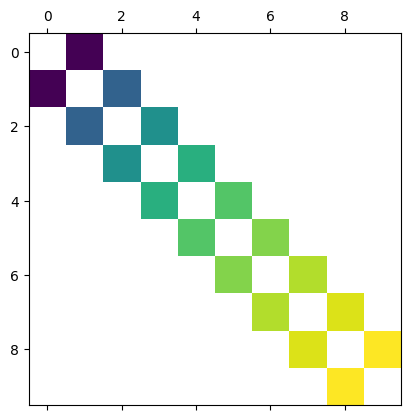

In [7]:
plt.matshow(XPConstants.RootsH[:10,:10], norm="log")

## 4. Analyse the lines of a lonesome XP spectrum

We start by reading some test XP data containing the 4 example Gaia DR3 stars discussed in the Weiler+2023 paper:

In [8]:
t = Table.read("./data/xp_continuous_combined_weiler2023_examples.vot")

source_id: 505171240162594560


<ErrorbarContainer object of 3 artists>

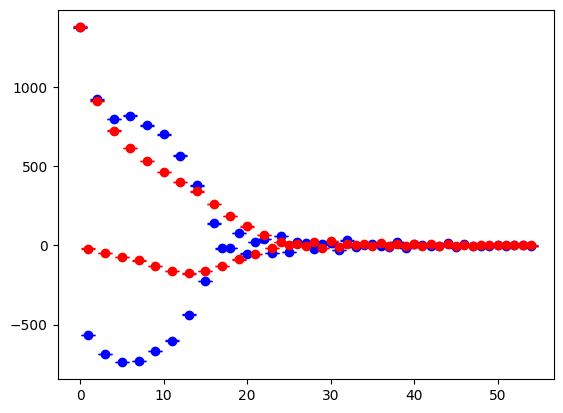

In [69]:
# Select the BP spectrum of one star
i       = 0
XP_spec = weiler2023_tools.XP_Spectrum(t[0], rotate_basis=True)
print("source_id:", XP_spec.source_id)

# Plot the transformed XP coefficients (except for the first) 
plt.errorbar(np.arange(0, len(XP_spec.BP)), XP_spec.BP, yerr=XP_spec.BP_err, capsize=5, fmt='o', c="b")
plt.errorbar(np.arange(0, len(XP_spec.RP)), XP_spec.RP, yerr=XP_spec.RP_err, capsize=5, fmt='o', c="r")

In [72]:
# Test if the covariance matrix is correctly transformed by comparing to Michael Weiler's results:
cov_BP = np.genfromtxt("./data/BP_CovarianceMatrix_Hermite.csv", delimiter=',')

print(cov_BP[:4,:4])         # Michael's calculation in R
print(XP_spec.BP_cov[:4,:4]) # python calculation

[[ 2.73354093 -0.25138946 -0.13024555 -0.09016454]
 [-0.25138946  2.56827854 -0.47777632 -0.23346239]
 [-0.13024555 -0.47777632  2.41540615 -0.62067335]
 [-0.09016454 -0.23346239 -0.62067335  2.37876927]]
[[ 2.73354093 -0.25138946 -0.13024555 -0.09016454]
 [-0.25138946  2.56827854 -0.47777632 -0.23346239]
 [-0.13024555 -0.47777632  2.41540615 -0.62067335]
 [-0.09016454 -0.23346239 -0.62067335  2.37876927]]


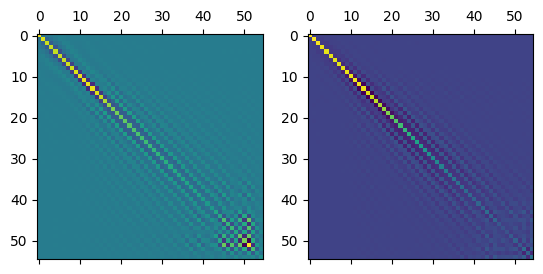

In [73]:
# Display the BP and RP covariance matrices in the transformed basis:
ax0 = plt.subplot(121)
ax0.matshow(XP_spec.BP_cov)
ax1 = plt.subplot(122)
ax1.matshow(XP_spec.RP_cov)

## 5. Run getLinesInNDeriv to get the extrema

In [75]:
res0= weiler2023_tools.getLinesInNDeriv(XP_spec.BP, XP_spec.BP_cov, N=0, instrument="BP", setup=None)
res2= weiler2023_tools.getLinesInNDeriv(XP_spec.BP, XP_spec.BP_cov, N=2, instrument="BP", setup=None)

# Again, check with MW's results - first for the 0th derivative:
michael = [-4.267470, 60.397974,  2.138676, 56.683008,  3.821615, 55.978256, 45.447909,
           44.974094, 15.984259, 16.239673, 17.207323]
michael_signif = [0.06278744,    1, 0.9999616, 0.8931181, 0.9931747, 0.9492456,
                  0.5992521, 0.7470524, 0.9941945, 0.9406041, 0.9999987]
# And the 2nd:
michael2= [-5.4582873, 62.5725492, -0.6776125, 59.6638148,  1.8276495, 57.4319832,  
           3.8104770, 55.6731154,  5.2276424, 54.3845021, 6.1164165, 53.1986057,  
           7.1039342, 52.3441929, 8.3178609, 50.9159719,  9.3827927, 49.5564988,
           10.7392059, 48.5742640, 11.5980516, 13.2495340, 45.8421456, 14.9477839, 
           44.3890963, 16.4034377, 43.0071458, 17.3600270, 18.4072012, 19.4185784,
           20.4243364, 21.2573757, 38.1568490, 22.1493887, 37.1105429, 23.1162599, 
           35.9353616, 24.4664784, 34.4921121, 26.1276414, 33.2055566, 27.3159329, 
           31.7433472, 28.4638737, 29.9265393 ]

In [57]:
res0["estimLinePos"]

array([-4.26747004,  2.13867583,  3.82161536, 15.98425946, 16.23967286,
       17.20732257, 60.39797413, 44.97409384, 45.44790914, 56.68300847,
       55.9782563 ])

In [59]:
res0["estimSignif"]

array([0.06278744, 0.99996157, 0.99317471, 0.99419451, 0.94060414,
       0.99999867, 1.        , 0.74705236, 0.59925208, 0.89311807,
       0.94924556])

In [63]:
res2["estimLinePos"]

array([-5.45828735, -0.67761247,  1.82764946,  3.81047697,  5.22764236,
        6.11641647,  7.10393423,  8.31786091,  9.38279265, 10.73920589,
       11.59805164, 13.24953403, 14.94778387, 16.40343767, 17.36002698,
       18.40720122, 19.4185784 , 20.42433639, 21.25737569, 22.1493887 ,
       23.11625987, 24.46647845, 26.12764138, 27.31593285, 28.46387374,
       29.92653933, 31.74334725, 33.20555664, 34.49211206, 35.93536165,
       37.11054289, 38.15684899, 43.00714575, 44.38909627, 45.84214559,
       48.57426397, 49.55649885, 50.91597191, 52.34419287, 53.19860575,
       54.38450214, 55.67311536, 57.43198325, 59.66381477, 62.57254924])

In [65]:
for k in res2.keys():
    print(k, res2[k])

N 2
estimLinePos [-5.45828735 -0.67761247  1.82764946  3.81047697  5.22764236  6.11641647
  7.10393423  8.31786091  9.38279265 10.73920589 11.59805164 13.24953403
 14.94778387 16.40343767 17.36002698 18.40720122 19.4185784  20.42433639
 21.25737569 22.1493887  23.11625987 24.46647845 26.12764138 27.31593285
 28.46387374 29.92653933 31.74334725 33.20555664 34.49211206 35.93536165
 37.11054289 38.15684899 43.00714575 44.38909627 45.84214559 48.57426397
 49.55649885 50.91597191 52.34419287 53.19860575 54.38450214 55.67311536
 57.43198325 59.66381477 62.57254924]
estimLineErr [1.68468486 0.32040494 0.27312708 0.31819886 0.44054432 0.38534183
 0.32609906 0.18861482 0.1118976  0.06778247 0.04116007 0.01542105
 0.0174558  0.03869162 0.06426307 0.08469162 0.10990428 0.15091292
 0.17295165 0.14615186 0.10341676 0.0934354  0.12932226 0.10163467
 0.07282717 0.07326057 0.07681676 0.05656067 0.06413741 0.13642353
 0.34031589 0.39041498 0.19314558 0.12160487 0.24953526 0.42942713
 0.3566741  0.25609

(5.0, 55.0, -5.0, 1622.5967684278132)

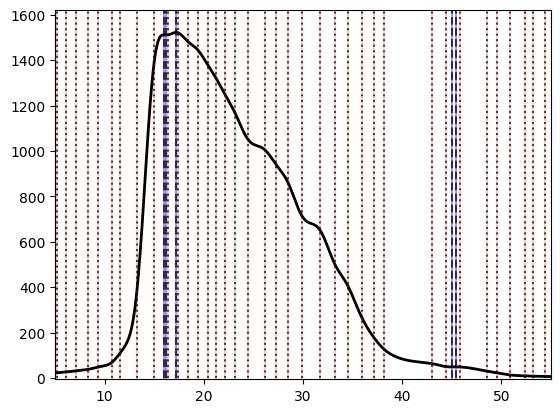

In [76]:
x           = np.linspace(-10,10, 1000)
l, internal = XP_spec.get_internal_spec(x, instrument="bp")
plt.plot(l, internal, c="k", lw=2)

plt.vlines(res0['estimLinePos'][res0['estimSignif']>1e-4], ymin=-100, ymax=np.max(internal)+100, alpha=0.4, color="blue")
#plt.vlines(res1['estimLinePos'][res1['estimSignif']>0.1], ymin=-100, ymax=np.max(internal)+100, alpha=0.1, color="grey")
plt.vlines(res2['estimLinePos'][res2['estimSignif']>0.1], ymin=-100, ymax=np.max(internal)+100, alpha=0.2, color="r")
plt.vlines(michael, ymin=0, ymax=np.max(internal)+100, alpha=0.7, color="k", ls="dashed")
plt.vlines(michael2, ymin=0, ymax=np.max(internal)+100, alpha=0.7, color="k", ls="dotted")

plt.axis([5, 55, -5, np.max(internal)+100])

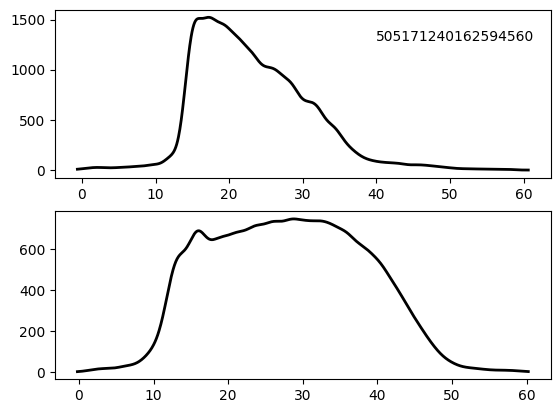

In [67]:
ax0 = plt.subplot(211)
l, internal = XP_spec.get_internal_spec(x, instrument="bp")
plt.plot(l, internal, c="k", lw=2)
plt.text(40, 0.85*np.max(internal), XP_spec.source_id)
ax1 = plt.subplot(212)
l, internal = XP_spec.get_internal_spec(x, instrument="rp")
plt.plot(l, internal, c="k", lw=2)

In [21]:
import importlib
importlib.reload(weiler2023_tools)

<module 'weiler2023_tools' from '/home/friedel/Desktop/xp_spectral_lines/weiler2023_tools.py'>